In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from zipfile import ZipFile
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset,DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
zip_path = "/content/drive/MyDrive/A-Z Dataset/A_Z Handwritten Data.csv.zip"

In [4]:
with ZipFile(zip_path) as zipfile:
    zipfile.extractall()

In [5]:
csv_path = "/content/A_Z Handwritten Data.csv"

In [6]:
df = pd.read_csv(csv_path)

In [7]:
df.shape

(372450, 785)

In [8]:
df.columns

Index(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9',
       ...
       '0.639', '0.640', '0.641', '0.642', '0.643', '0.644', '0.645', '0.646',
       '0.647', '0.648'],
      dtype='object', length=785)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372450 entries, 0 to 372449
Columns: 785 entries, 0 to 0.648
dtypes: int64(785)
memory usage: 2.2 GB


In [10]:
X = df.drop('0',axis = 1).to_numpy() # axis=1 is to say to drop along the columns
y = df['0'].to_numpy()

In [11]:
X.shape

(372450, 784)

In [12]:
y.shape

(372450,)

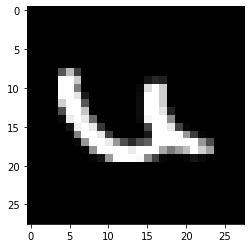

In [13]:
index = np.random.randint(0,372450)
plt.imshow(X[index].reshape(28,28),cmap="gray")

In [14]:
372450 * 0.2 # size of the testing data

74490.0

In [15]:
372450 - 74490 # size of the training data

297960

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [17]:
del df

In [18]:
X_train.shape,y_train.shape

((297960, 784), (297960,))

In [19]:
X_test.shape,y_test.shape

((74490, 784), (74490,))

In [20]:
297960 * 0.2 # val dataset size

59592.0

In [21]:
297960 - 59592 # training dataset size

238368

In [22]:
# now take some for validation
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)

In [23]:
X_train.shape,X_val.shape

((238368, 784), (59592, 784))

In [24]:
y_train.shape,y_val.shape

((238368,), (59592,))

In [25]:
class Alphabets(Dataset):

  def __init__(self,X,y,transform=None):
    self.X = X
    self.y = y
    self.transform = transform
  
  def __len__(self):
    return len(self.X)
  
  def __getitem__(self,index):
    # np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((input_size, input_size)).convert('RGB'))

    image = Image.fromarray(((self.X[index]).astype(np.uint8)).reshape(28,28))
    label = self.y[index]

    if self.transform != None:
      image = self.transform(image)
    
    return image,label


In [26]:
transform = transforms.Compose([
         transforms.ToTensor(),
         transforms.RandomAffine(degrees=(-50,50),
                                 translate=(0.1, 0.2))                      
])

In [27]:
X_train.shape,X_test.shape,X_val.shape

((238368, 784), (74490, 784), (59592, 784))

In [28]:
y_train.shape,y_test.shape,y_val.shape

((238368,), (74490,), (59592,))

In [29]:
train_dataset = Alphabets(X_train,y_train,transform)
test_dataset = Alphabets(X_test,y_test,transform)
val_dataset = Alphabets(X_val,y_val,transform)

In [30]:
len(train_dataset),len(test_dataset),len(val_dataset)

(238368, 74490, 59592)

In [31]:
train_dataset_loader = DataLoader(train_dataset,batch_size=100,shuffle=True)
test_dataset_loader = DataLoader(test_dataset,batch_size=100,shuffle=True)
val_dataset_loader = DataLoader(val_dataset,batch_size=100,shuffle=True)

In [32]:
import torchvision

inputs_batch, labels_batch = next(iter(train_dataset_loader))
grid = torchvision.utils.make_grid(inputs_batch, nrow=40, pad_value=1)
torchvision.utils.save_image(grid, 'inputs_batch_preview.png')


<class 'list'>
2
100
100
torch.Size([100, 1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([100])
torch.Size([])
label ::  18


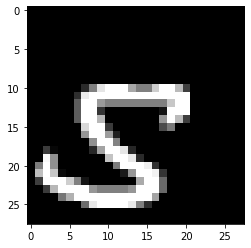

In [33]:
df = iter(train_dataset_loader)
df = next(df)

print(type(df))
print(len(df))

print(len(df[0]))
print(len(df[1]))

print(df[0].shape)
print(df[0][0].shape)

print(df[1].shape)
print(df[1][0].shape)


plt.imshow(df[0][0].reshape(28,28),cmap="gray")
print("label :: ",df[1][0].item())

In [34]:
config = [
     # input_channels:int,no.of filters:int,filter_size:int,stride:int,padding:int
     (1,16,3,1,1),
     # MP - max pooling:string,filter_size:int,stride:int,padding:int
     ("MP",2,2,0),
     (16,32,3,1,1),
     ("MP",2,2,0),
     (32,64,3,1,1),
     ("MP",2,2,0),
     (64,128,3,1,1),
     ("MP",2,2,0),
]

In [35]:
def conv_output_size(img_size,padding,filter_size,stride,n_filters):
   size_ = (int((img_size + (2 * padding) - filter_size) / stride)) + 1
   return size_,size_,n_filters

In [36]:
def dense_layer_size(configuration,img_size):

  _,output_channels = 0,0
  layer_count = 0

  for config in configuration:
    
    layer_count += 1

    if config[0] == "MP":
      img_size,_,output_channels = conv_output_size(img_size,config[3],config[1],config[2],output_channels)
      print("Max Pooling Layer {} output dims :: ".format(layer_count),img_size,_,output_channels)

    else: 
      img_size,_,output_channels = conv_output_size(img_size,config[4],config[2],config[3],config[1])
      print("Conv Layer {} output dims :: ".format(layer_count),img_size,_,output_channels)
  
  return img_size,_,output_channels

In [37]:
width,heigth,channels = dense_layer_size(config,28)

Conv Layer 1 output dims ::  28 28 16
Max Pooling Layer 2 output dims ::  14 14 16
Conv Layer 3 output dims ::  14 14 32
Max Pooling Layer 4 output dims ::  7 7 32
Conv Layer 5 output dims ::  7 7 64
Max Pooling Layer 6 output dims ::  3 3 64
Conv Layer 7 output dims ::  3 3 128
Max Pooling Layer 8 output dims ::  1 1 128


In [38]:
class NeuralNetwork(nn.Module):

  def __init__(self):
    super(NeuralNetwork,self).__init__()

    self.layer1 = nn.Sequential(
      nn.Conv2d(1,16,3,1,1),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
    )

    self.layer2 = nn.Sequential(
      nn.Conv2d(16,32,3,1,1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
    )

    self.layer3 = nn.Sequential(
      nn.Conv2d(32,64,3,1,1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
    )

    self.layer4 = nn.Sequential(
      nn.Conv2d(64,128,3,1,1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
    )

    self.FC = nn.Sequential(
      nn.Linear(128,26)
    )


  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = torch.flatten(x,1)
    x = self.FC(x)

    return x



In [39]:
net = NeuralNetwork()
net.train()

NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): B

In [40]:
lr = 0.01
optim = torch.optim.Adam(net.parameters(),lr)
loss_fn = nn.CrossEntropyLoss()

In [41]:
epochs = 15

train_len = len(train_dataset_loader)
val_len = len(val_dataset_loader)

training_accuracy = []
training_loss = []

validation_accuracy = []
validation_loss = []

for epoch in range(epochs):

  epoch_acc = 0
  epoch_loss = 0

  for batch_id,(image,label) in enumerate(train_dataset_loader):

    output = net(image)

    loss = loss_fn(output,label)

    optim.zero_grad()
    loss.backward()
    optim.step()

    acc = (output.argmax(dim=1) == label).float().mean()
    epoch_acc += (acc.item() / len(train_dataset_loader)) 
    epoch_loss += (loss.item() / len(train_dataset_loader)) 
  
  print(f"Epoch :: [{epoch+1}/{epochs}] Train Accuracy :: {epoch_acc:.4f} Train Loss :: {epoch_loss:.4f}") 
  
  training_accuracy.append(epoch_acc)
  training_loss.append(epoch_loss)

  with torch.no_grad():

    epoch_val_accuracy = 0
    epoch_val_loss = 0
    
    for batch_id,(image, label) in enumerate(val_dataset_loader):
  
      val_output = net(image)
      val_loss = loss_fn(val_output,label)
      
      val_acc = ((val_output.argmax(dim=1) == label).float().mean())
      epoch_val_accuracy += (val_acc.item() / len(val_dataset_loader))  
      epoch_val_loss += (val_loss.item() / len(val_dataset_loader))

    print(f"Epoch :: [{epoch+1}/{epochs}] Val Accuracy :: {epoch_val_accuracy:.4f} Val Loss :: {epoch_val_loss:.4f}")

    validation_accuracy.append(epoch_val_accuracy)
    validation_loss.append(epoch_val_loss)
    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch :: [1/15] Train Accuracy :: 0.9024 Train Loss :: 0.3273
Epoch :: [1/15] Val Accuracy :: 0.9426 Val Loss :: 0.1917
Epoch :: [2/15] Train Accuracy :: 0.9470 Train Loss :: 0.1766
Epoch :: [2/15] Val Accuracy :: 0.9522 Val Loss :: 0.1590
Epoch :: [3/15] Train Accuracy :: 0.9545 Train Loss :: 0.1551
Epoch :: [3/15] Val Accuracy :: 0.9540 Val Loss :: 0.1534
Epoch :: [4/15] Train Accuracy :: 0.9568 Train Loss :: 0.1436
Epoch :: [4/15] Val Accuracy :: 0.9609 Val Loss :: 0.1309
Epoch :: [5/15] Train Accuracy :: 0.9602 Train Loss :: 0.1341
Epoch :: [5/15] Val Accuracy :: 0.9619 Val Loss :: 0.1273
Epoch :: [6/15] Train Accuracy :: 0.9614 Train Loss :: 0.1281
Epoch :: [6/15] Val Accuracy :: 0.9601 Val Loss :: 0.1378
Epoch :: [7/15] Train Accuracy :: 0.9632 Train Loss :: 0.1252
Epoch :: [7/15] Val Accuracy :: 0.9633 Val Loss :: 0.1239
Epoch :: [8/15] Train Accuracy :: 0.9648 Train Loss :: 0.1186
Epoch :: [8/15] Val Accuracy :: 0.9634 Val Loss :: 0.1265
Epoch :: [9/15] Train Accuracy :: 0.9656

In [42]:
torch.save(net.state_dict(), "englishv2.pt")

In [43]:
net.eval()

NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): B

In [44]:
with torch.no_grad():

    epoch_test_acc = 0
    epoch_test_loss = 0
    
    for batch_id,(image, label) in enumerate(test_dataset_loader):
  
      test_output = net(image)
      test_loss = loss_fn(test_output,label)
      
      val_acc = ((test_output.argmax(dim=1) == label).float().mean())
      epoch_test_acc += (val_acc.item() / len(test_dataset_loader)) * 100 
      epoch_test_loss += (test_loss.item() / len(test_dataset_loader)) * 100
     
    print(f"Accuracy :: {epoch_test_acc:.4f}  Loss :: {epoch_test_loss:.4f}")


Accuracy :: 96.9915  Loss :: 9.9454


In [45]:
net = NeuralNetwork()
net.load_state_dict(torch.load("/content/englishv2.pt"))

<All keys matched successfully>

In [74]:
transform = transforms.Compose([
         transforms.ToTensor(),
         transforms.RandomAffine(degrees=(-50,50),
                                 translate=(0.2, 0.2),
                                 scale=(0.5, 0.75))                      
])

transform_test = transforms.Compose([
            transforms.ToTensor()
])

In [75]:
train_dataset = Alphabets(X_train,y_train,transform)
test_dataset = Alphabets(X_test,y_test,transform_test)
val_dataset = Alphabets(X_val,y_val,transform)

In [76]:
train_dataset_loader = DataLoader(train_dataset,batch_size=100,shuffle=True)
test_dataset_loader = DataLoader(test_dataset,batch_size=100,shuffle=True)
val_dataset_loader = DataLoader(val_dataset,batch_size=100,shuffle=True)

<class 'list'>
2
100
100
torch.Size([100, 1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([100])
torch.Size([])
label ::  20


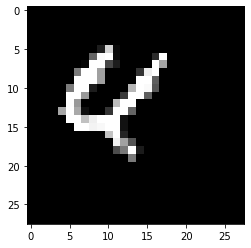

In [62]:
df = iter(train_dataset_loader)
df = next(df)

print(type(df))
print(len(df))

print(len(df[0]))
print(len(df[1]))

print(df[0].shape)
print(df[0][0].shape)

print(df[1].shape)
print(df[1][0].shape)


plt.imshow(df[0][0].reshape(28,28),cmap="gray")
print("label :: ",df[1][0].item())

In [65]:
net.train()

NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): B

In [66]:
epochs = 15

train_len = len(train_dataset_loader)
val_len = len(val_dataset_loader)

training_accuracy = []
training_loss = []

validation_accuracy = []
validation_loss = []

for epoch in range(epochs):

  epoch_acc = 0
  epoch_loss = 0

  for batch_id,(image,label) in enumerate(train_dataset_loader):

    output = net(image)

    loss = loss_fn(output,label)

    optim.zero_grad()
    loss.backward()
    optim.step()

    acc = (output.argmax(dim=1) == label).float().mean()
    epoch_acc += (acc.item() / len(train_dataset_loader)) 
    epoch_loss += (loss.item() / len(train_dataset_loader)) 
  
  print(f"Epoch :: [{epoch+1}/{epochs}] Train Accuracy :: {epoch_acc:.4f} Train Loss :: {epoch_loss:.4f}") 
  
  training_accuracy.append(epoch_acc)
  training_loss.append(epoch_loss)

  with torch.no_grad():

    epoch_val_accuracy = 0
    epoch_val_loss = 0
    
    for batch_id,(image, label) in enumerate(val_dataset_loader):
  
      val_output = net(image)
      val_loss = loss_fn(val_output,label)
      
      val_acc = ((val_output.argmax(dim=1) == label).float().mean())
      epoch_val_accuracy += (val_acc.item() / len(val_dataset_loader))  
      epoch_val_loss += (val_loss.item() / len(val_dataset_loader))

    print(f"Epoch :: [{epoch+1}/{epochs}] Val Accuracy :: {epoch_val_accuracy:.4f} Val Loss :: {epoch_val_loss:.4f}")

    validation_accuracy.append(epoch_val_accuracy)
    validation_loss.append(epoch_val_loss)
    

Epoch :: [1/15] Train Accuracy :: 0.7068 Train Loss :: 0.9891
Epoch :: [1/15] Val Accuracy :: 0.7060 Val Loss :: 1.0032
Epoch :: [2/15] Train Accuracy :: 0.7082 Train Loss :: 0.9885
Epoch :: [2/15] Val Accuracy :: 0.7061 Val Loss :: 0.9996
Epoch :: [3/15] Train Accuracy :: 0.7067 Train Loss :: 0.9906
Epoch :: [3/15] Val Accuracy :: 0.7066 Val Loss :: 0.9969
Epoch :: [4/15] Train Accuracy :: 0.7060 Train Loss :: 0.9940
Epoch :: [4/15] Val Accuracy :: 0.7047 Val Loss :: 0.9960
Epoch :: [5/15] Train Accuracy :: 0.7058 Train Loss :: 0.9918
Epoch :: [5/15] Val Accuracy :: 0.7028 Val Loss :: 0.9957
Epoch :: [6/15] Train Accuracy :: 0.7078 Train Loss :: 0.9896
Epoch :: [6/15] Val Accuracy :: 0.7054 Val Loss :: 1.0007
Epoch :: [7/15] Train Accuracy :: 0.7073 Train Loss :: 0.9901
Epoch :: [7/15] Val Accuracy :: 0.7069 Val Loss :: 1.0001
Epoch :: [8/15] Train Accuracy :: 0.7076 Train Loss :: 0.9912
Epoch :: [8/15] Val Accuracy :: 0.7063 Val Loss :: 0.9957
Epoch :: [9/15] Train Accuracy :: 0.7061

In [67]:
torch.save(net.state_dict(), "englishv3.pt")

In [68]:
net.eval()

NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): B

In [77]:
with torch.no_grad():

    epoch_test_acc = 0
    epoch_test_loss = 0
    
    for batch_id,(image, label) in enumerate(test_dataset_loader):
  
      test_output = net(image)
      test_loss = loss_fn(test_output,label)
      
      val_acc = ((test_output.argmax(dim=1) == label).float().mean())
      epoch_test_acc += (val_acc.item() / len(test_dataset_loader)) * 100 
      epoch_test_loss += (test_loss.item() / len(test_dataset_loader)) * 100
     
    print(f"Accuracy :: {epoch_test_acc:.4f}  Loss :: {epoch_test_loss:.4f}")


Accuracy :: 93.2270  Loss :: 30.5731
